In [2]:
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt
%matplotlib inline

(202, 278)


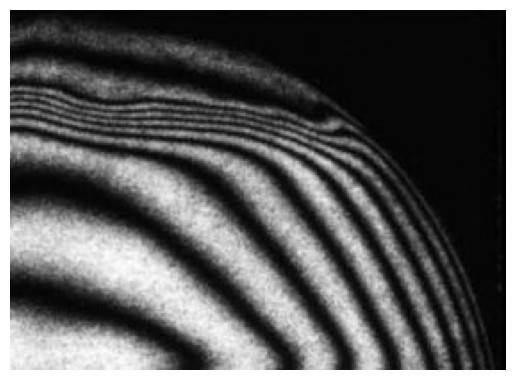

In [3]:
img_path = '1.jpg'

img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
print(img.shape)

plt.imshow(img, cmap ='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

In [120]:
class Circle:
    
    def __init__(self, i: int, j: int, r: int, M: int) -> None:
        self.c = np.array([i, j])
        self.r = r
        self.M = M

        self.angles = [2*np.pi*i/self.M for i in range(self.M)]
        self.points = []
        self.calc_points_()
        
        self.intencity = []

    def calc_points_(self):
        self.points = [self.c + np.array([self.r*np.cos(alpha), self.r*np.sin(alpha)]).astype(np.int32) for alpha in self.angles]

    def project_intencity(self, img) -> np.ndarray:
        self.intencity = np.array([img[*p] for p in self.points])

        return self.intencity

    def calcA(self) -> float:
        return 0.5*(np.max(self.intencity) - np.min(self.intencity))

    def calcD(self) -> float:
        D = 0.5*np.sum(np.abs(self.intencity[1:]-self.intencity[:-1]))
        return D

    def update_r(self, r):
        self.r = r
        self.calc_points_()
        self.intencity = []

    def draw(self, img):
        img_out = copy.deepcopy(img)

        for p in self.points:
            #print(point, p, img_in[*p], sep=": ")
            if img[*p] < 150:
                img_out[*p] = 255
            else:
                img_out[*p] = 0

        return img_out


In [114]:
def draw_circle(img_in: np.ndarray, c: Circle) -> np.ndarray:
    img_out = copy.deepcopy(img_in)
         
    for p in c.points:
            #print(point, p, img_in[*p], sep=": ")
        try:
            pint = img_in[*p]
        except IndexError:
            pass
        else:
            if pint < 150:
                img_out[*p] = 255
            else:
                img_out[*p] = 0

    return img_out

In [110]:
def draw_circles(img_in: np.ndarray, dx: int, dy: int, r:int, M: int) -> np.ndarray:
    img_out = copy.deepcopy(img_in)
    
    nx = (img_in.shape[0])//dx - 1 
    ny = (img_in.shape[1])//dy - 1

    points = [[x, y] for x in [d*(i+1) for i in range(nx)] for y in [d*(i+1) for i in range(ny)]]
    #print(points)
    #print(*points[1])

    for point in points:
        c = Circle(*point, r, M)
        for p in c.points:
            #print(point, p, img_in[*p], sep=": ")
            if img_in[*p] < 150:
                img_out[*p] = 255
            else:
                img_out[*p] = 0

    return img_out
    

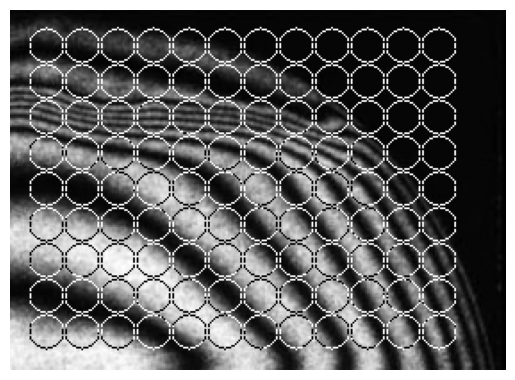

In [107]:
img_c = draw_circles(img, 20,10,50)

plt.imshow(img_c, cmap ='gray', vmin=0, vmax=255)
plt.axis('off')
plt.show()

# lower we implement an algoritm for iterative smoothing of an image
1. firstly, we extract lines along given direction from image
2. secondly, we create a linear weight function g(x)
3. thirdly, we compute a modified histogram, which is calculated as
   \begin{equation}
   h(\xi_j) = \sum_{i=-L/2}^{L/2} {g(x_i)\delta(\xi(g(x_i)-\xi_j))}
   \end{equation}
   This histogramm accounts for decreasing with distance connection betweeen intencities of the middle point and points $x_i$ of the interval. Function $g(x)$ provides weights to contributions of points to the histogram.
4. next, we choose sample length $L$, starting from $n = 0$ we move interval $[x_n: x_{n+L}]$ along extracted line. For each n histogram is calculated and intencity of the central point $x_c$, where $c = n+L//2$ is restored from said histogram according to expression:
   \begin{equation}
   \xi_{aver}(x_c) = \sum_{i=0}^{255} {\xi_i h(\xi_i)}
   \end{equation}

In [85]:
def get_line(img, alpha, x0) -> tuple:
    line = []
    points = []
    
    x_max = img.shape[0]-1
    y_max = img.shape[1]-1

    y = 0
    x = x0

    if alpha > np.pi/4:
 
        while y <= y_max and x <= x_max:
            y = int((x - x0)/np.tan(alpha))
            if y <= y_max:
                points.append([x,y])
                line.append(int(img[x,y]))
            x = x + 1
    else:

        while y <= y_max and x <= x_max:
            x = int(y*np.tan(alpha)) + x0
            if x <= x_max:
                points.append([x,y])
                line.append(int(img[x,y]))
            y = y + 1        

    return line, points

def _get_lower_half(diag: list, check_last: int, x_max: int) -> tuple[list[list[int]], list[list[int,int]]]:

    new_points = diag
    lines = []
    points = []
    
    for _ in range(x_max):
        ending = []
        for p in new_points[-check_last:]:
            if p[0] < x_max:
                ending.append([p[0]+1,p[1]])
                
        new_points = [[p[0]+1, p[1]] for p in new_points[:-check_last]]
        new_points += ending

        points.append(new_points)

        lines.append([img[*p] for p in new_points])

    return lines, points

def _get_upper_half(diag: list, check_last: int, y_max: int) -> tuple[list[list[int]], list[list[int,int]]]:

    new_points = diag
    lines = []
    points = []

    for _ in range(1,y_max):
        ending = []
        for p in new_points[-check_last:]:
            if p[1] < y_max:
                ending.append([p[0],p[1]+1])
                
        new_points = [[p[0], p[1]+1] for p in new_points[:-check_last]]
        new_points += ending

        points.append(new_points)

        lines.append([img[*p] for p in new_points])
        
    lines.reverse()
    points.reverse()

    return lines, points

def get_direction(img: np.ndarray, alpha: float) -> tuple[list[list[int]], list[list[int,int]]]:
    lines = []
    points = []

    check_last_x = 1
    check_last_y = 1
    if alpha < np.pi/4:
        check_last_x = int(1/np.tan(alpha)) + 1
    else:
        check_last_y = int(np.tan(alpha)) + 1

    x_max = img.shape[0]-1
    y_max = img.shape[1]-1

    _, diag = get_line(img, alpha, 0)

    lines_up, points_up = _get_upper_half(diag, check_last_y, y_max)
    lines_down, points_down = _get_lower_half(diag, check_last_x, x_max)

    lines = lines_up + lines_down
    points = points_up + points_down
    
    return lines, points


def direction_img(lines: list) -> np.ndarray:
    max_len = max(list(map(len, lines)))

    img = np.zeros((len(lines), max_len))

    for i, line in enumerate(lines):
        img[i,:len(line)] = line
    return img

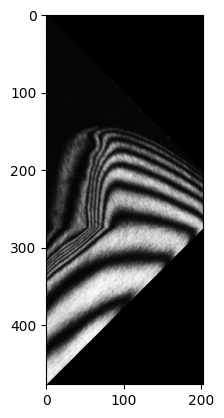

In [87]:
alpha = np.pi/4
dlines, dpoints = get_direction(img, alpha)

line_img = direction_img(dlines)
plt.figure()
plt.imshow(line_img, cmap='gray', vmin=0, vmax=255)

In [84]:
a = [[x,y] for x,y in zip(list(range(10)), list(range(10,20)))]
a.append([10,20])
a.reverse()
print(a+a)

[[10, 20], [9, 19], [8, 18], [7, 17], [6, 16], [5, 15], [4, 14], [3, 13], [2, 12], [1, 11], [0, 10], [10, 20], [9, 19], [8, 18], [7, 17], [6, 16], [5, 15], [4, 14], [3, 13], [2, 12], [1, 11], [0, 10]]


In [35]:
def draw_points(img, points) -> np.ndarray:
    img_out = copy.deepcopy(img)

    for point in points:
        try:
            img_p = img[*point]
        except IndexError:
            pass
        else:
            img_out[*point] = 0 if img_p > 120 else 255

    return img_out

In [5]:
def g_linear(K:int) -> list:
    if K%2 == 0:
        g_first = [i for i in range(K//2)]
        a = K/2/sum(g_first)
        g_first = [a*i for i in g_first]

        g = g_first + g_first[::-1]

    else:
        g_first = [i for i in range(K//2 + 1)]
        g = g_first + g_first[K//2-1::-1]
        a = K/sum(g)

        g = [a*i for i in g]
        
    return g

def hist(points: list[int]) -> list:
    hist = [0]*255

    p_len = len(points)
    
    g_funk = g_linear(p_len)
    for p, g in zip(points, g_funk):
        hist[p] += g

    return hist

def average_hist_sample(points: list) -> float:
    histogramm = hist(points)
    hist_range = [i for i in range(255)]
    p_len = len(points)

    avr_cp = round(sum([i*h for i, h in zip(hist_range, histogramm)])/p_len)
    return avr_cp

def average_line(line: list[list], L: int) -> list[list]:
    seq_len = len(line)
    new_line = line[:L//2]
    
    for i in range(seq_len-L):
        points = line[i:i+L]
        p_new = average_hist_sample(points)
    
        new_line.append(p_new)

    new_line += line[-L//2:]
        
    return new_line

In [61]:
alpha = np.pi/3
x0 = 20

line, points = get_line(img, alpha, x0)

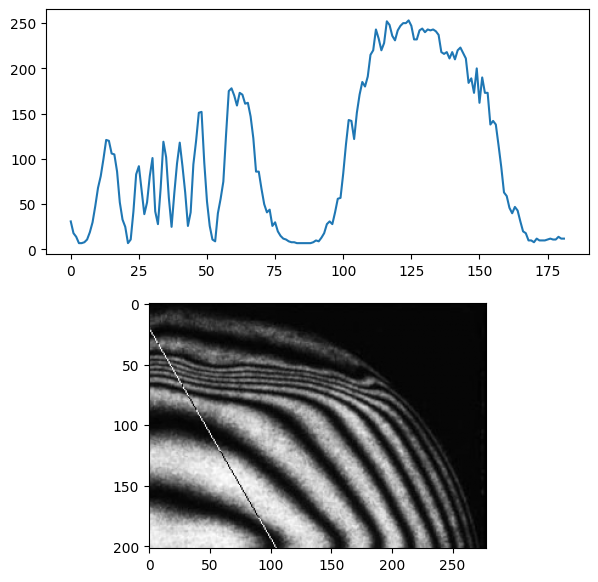

In [62]:
img_line = draw_points(img, points)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax1.plot(line)

ax2.imshow(img_line, cmap='gray', vmin=0, vmax=255)
plt.show()

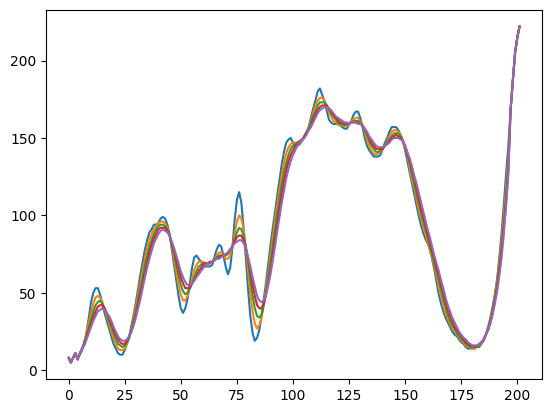

In [32]:
L = 10
new_line = line
for _ in range(5):
    new_line = average_line(new_line, L)

    #plt.figure()
    plt.plot(new_line)

## We have implemented Gurov's filtering method to one dimentional signal, now it is nesassary to extend it to 2D-signals (images)

### At last, the length of averaging interval for histogram generation must be calculated interactively, depending on the data analysed

To achieve it, the following method is proposed:

~~Note, that $L$ must be minimal if local fringe pattern is perpendiculat to line direction and $L$ can be larger, if the line lyes anong the fringe.~~
To use the same $L$ along all directions and points $p_{i,j}$ with nither loosing small details of the signal, nor interpreting noize as usefull signal, we calculate $\xi (p_{i,j})$ as weighted averaged across directions of lines.
Let's considere a point on an image and lines, going through this point:
the direction of line $l$, along which gradient of intencity is the lowest, can be considered the closest to fringe direction

1. For now, instead of gradient, we can use dispertion, given by:
   \begin{equation}
   D(x_i) \equiv D(i,j,l) = \sum_{j=i-L//2}^{i+L//2} {(\xi (x_j) - \langle \xi \rangle)^2}
   \end{equation}
2. Direction $l$, which priduces the smallest dispersion is considered as direction along the fridge.
3. The dispertions $D(i,j,l)$ are averaged in 2D area $[i-di:i+di] \times [j-dj:j+dj]$ for all $l$, the result is assigned to $C(i,j,l)$.
4. The finel intensity at point $p(i,j)$ is calculated as follows:
   \begin{equation}
   \xi (i,j) = \sum_{l} {\xi (i,j,l) C(i,j,l^{trans})}/ \sum_{l} {C(i,j,l^{trans})}
   \end{equation}

In [59]:
def dispersion(points_xi: list) -> float:
    points_xi = [int(p) for p in points_xi]
    L = len(points_xi)
    xi_aver = sum(points_xi)/L
    
    D = sum([(xi_p - xi_aver)**2 for xi_p in points_xi])/L/L
    return D

def line_dispertion(line_xi: list, L: int) -> list:
    d_list = []

    
    p_count = len(line_xi)
    for i in range(p_count):

        if i<L//2:
            points = line_xi[0:2*i+1]
        elif i > p_count-1-L//2:
            i_ = p_count-1-i
            points = line_xi[p_count-1-2*i_:p_count]
        else:
            points = line_xi[i-L//2:i+L//2+1]
                
        d_list.append(dispersion(points))

    return d_list
            
        

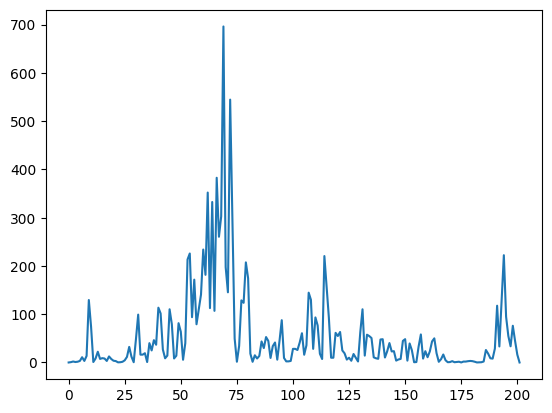

In [38]:
list_lines

[0]